<a href="https://colab.research.google.com/github/MweinbergUmass/Teach_Dimred/blob/main/pcadisplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


For newbies, all you have to do should be to press the run button on the side of each cell too see the output of the code blocks.

First run the cells for installing and importing the nescessary dependencies.

In [ ]:
pip install mpl_interactions pca

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_interactions.ipyplot as iplt
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from sklearn.datasets import load_iris, load_digits
from pca import pca as dooppypca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


Disclaimer: I wrote this originally all in a matlab live editor so there might be some residual errors particularly in the code for display.

In order to talk about PCA there are a few concepts we should get under our belt first.


Specifically, Variance and Covariance.


Lets start with variance, which makes for an easy generalization to covariance.


IMPORTANT NOTE: When we use dimensionality reduction techniques, it is helpful to think about our columns as features and our rows as data points.


$$var(X)=\sum_{i=1}^n \frac{1}{n-1}(X_i -\mu )^2$$

Where $\mu$ is the sample mean.


In code:


The scalar of n-1 comes from what's called Bessel correction, it's a technicality so don't worry too much about it. (Its for when you only have a sample and not the full population)

<pre>
def compute_variance(X):
    n = X.shape[1]
    mu = np.mean(X, axis=0)
    scaler = 1 / (X.shape[0] - 1)
    variance = np.zeros(n)
    for i in range(n):
        variance[i] = scaler * np.sum((X[:, i] - mu[i]) ** 2)
    return variance

</pre>

Disclaimer 2: In practice you should always use numpy or another trusted library to compute variance. Their operations will be much faster. For example:

<pre>
var = np.var(X)
</pre>


Here's a plot that showcases what variance looks like. As you can see it is the "spread" of the data.


In [ ]:
#Initializing my variables
N = 100
mu = [0, 0]
variances = [0.5, 1, 2, 5, 7.5, 10]

# Create a new figure
plt.figure(figsize=(10, 7))

for i, var in enumerate(variances):
    # generating random points from a 2 dimensional gaussian
    sigma = np.array([[var, 0], [0, var]])
    points = np.random.multivariate_normal(mu, sigma, N)

    # plotting
    plt.subplot(2, 3, i+1)
    plt.scatter(points[:, 0], points[:, 1], s=5)
    plt.title(f'Variance = {var}')
    plt.axis('equal')
    plt.grid(True)
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])

plt.tight_layout()
plt.show()



Our data can also vary in multiple directions (adjust the sliders):


In [ ]:
N = 50
mu = [0, 0]
#function for plotting points based on the variance
def plot_points(varx, vary):
    sigma = np.array([[varx, 0], [0, vary]])
    points = np.random.multivariate_normal(mu, sigma, N)

    plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 1], s=5)
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.title(f"Variance x: {varx}, Variance y: {vary}")
    plt.show()

widgets.interactive(plot_points,
                    varx=widgets.FloatSlider(value=1, min=1, max=100, step=1, description='Var x:'),
                    vary=widgets.FloatSlider(value=1, min=1, max=100, step=1, description='Var y:'))



We can also calculate how different variables covary, or vary together. The formula for covariance is very similar:


$$Cov(X,Y)=\sum_{i=1}^n \frac{1}{n-1}(X_i -X_{\mu } )(Y_i -Y_{\mu } )$$

 In code:




<pre>
def Cov(X):
    n, m = X.shape  # n = number of data points, m = features
    scalar = 1 / (n - 1)  # Bessel correction
    cov_matrix = np.zeros((m, m))  # initialize covariance matrix
    X_mu = np.mean(X, axis=0)  # mean of each feature in X
    
    for i in range(m):
        T_1 = X[:, i] - X_mu[i]  # term 1 doesn't need to be iterated in the inner loop
        for j in range(m):
            cov_matrix[i, j] = np.sum(T_1 * (X[:, j] - X_mu[j]))  # for each other variable
            cov_matrix[i, j] = cov_matrix[i, j] * scalar
            
    return cov_matrix

#output is an m by m matrix where the diagonal is the variance of each variable
#and the off diagonal is how variable i covary's with variable j.

</pre>

Disclaimer 3: Same as before, use something like:
<pre>
cov_np = np.cov(X, rowvar=False) #Our columns are variables.
</pre>


As you can see, in the case where X and Y are the same this just becomes the formula for variance:


$$var(X)=\sum_{i=1}^n \frac{1}{n-1}(X_i -X_{\mu } )^2$$

When we use PCA we make use of the covariance matrix:


$$S=w^T w$$

The covariance matrix is defined as a matrix where the nth element gives the covariance between datapoint i and variable j.


The diagonal of $S$ is simply the variance of the ith element.


To see covariance in action lets take a look at these plots:


In [ ]:
# Seting the seed for reproducibility
np.random.seed(42)

N = 50

# positive cov data
X_pos = np.linspace(0, 10, N)
Y_pos = X_pos + 5 + np.random.randn(N)

# negative cov data
X_neg = np.linspace(0, 10, N)
Y_neg = -X_neg + np.random.randn(N)

# Generate data with no (or very little) covariance
X_none = np.linspace(0, 10, N)
Y_none = 5 + np.random.randn(N)

# plotting
plt.figure()
plt.scatter(X_pos, Y_pos, c='b', linewidth=2)
plt.xlim([0, 10])
plt.ylim([0, 20])
plt.grid(True)
covmat_pos = np.cov(X_pos, Y_pos)
plt.title(f"Positive Covariance: Cov(X, Y) = {covmat_pos[0,1]:.2f}", fontsize=14)
plt.show()

plt.figure()
plt.scatter(X_neg, Y_neg, c='r', linewidth=2)
plt.xlim([0, 10])
plt.ylim([-10, 10])
plt.grid(True)
covmat_neg = np.cov(X_neg, Y_neg)
plt.title(f"Negative Covariance: Cov(X, Y) = {covmat_neg[0,1]:.2f}", fontsize=14)
plt.show()

plt.figure()
plt.scatter(X_none, Y_none, c='g', linewidth=2)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.grid(True)
covmat_none = np.cov(X_none, Y_none)
plt.title(f"No Covariance: Cov(X, Y) = {covmat_none[0,1]:.2f}", fontsize=14)
plt.show()


Let's go back to our original data set where we set the variance in the x and y direction and let's see if we can find the line that maximizes the variance. We will then use this line as part of our new coordinate system. The values of our data will be given by their projections (I'll go over this in a second) on the line. This makes for an optimal representation because the direction of maximal variance is often the one where information is lies.


In [ ]:
# Generating some points with positive covariance
n_points = 50
x_values = np.random.uniform(-10, 10, n_points)
m = 1.5
b = 0
noise = np.random.normal(0, 2, n_points)
y_values = m * x_values + b + noise
points = np.column_stack((x_values, y_values))

def plot_with_slope(m):
    plt.figure(figsize=(8,6))

    plt.scatter(points[:, 0], points[:, 1], color='blue', linewidth=2)

    xLims = np.array([-10, 10])
    plt.xticks(np.linspace(-10,10,5))
    plt.xlim([-10,10])
    plt.ylim([-10,10])

    b = 0
    plotline(m, xLims, b)

    # Direction vector for the line
    u = np.array([1, m])
    u = u / np.linalg.norm(u)  # normalize vector

    # project points and plot line
    for point in points:
        v = point
        proj = (np.dot(v, u) / np.dot(u, u)) * u
        plt.plot([point[0], proj[0]], [point[1], proj[1]], 'r--')

    plt.show()

def plotline(m, x, b):
    y = m*x + b
    plt.plot(x, y, linewidth=2)


widgets.interactive(plot_with_slope, m=widgets.FloatSlider(value=-10, min=-20, max=20, step=0.5))


In order to find the line that maximizes the variance PCA looks for the line that minimizes the sum of perpendicular square distances to the line.
Hopefully as you saw by playing with the slider, you get the intuiton that this is the line that maximizes the variance.

Lets take a look at exactly what I mean. Here you can play with the sliders which will adjust the variance in the x and y direction and plot the corresponding principal component.

In [ ]:
def plot_with_variances(variancex, variancey):
    sigma = np.array([[variancex, 0], [0, variancey]])

    # unimportant arbitrary choices for these values
    mu = np.array([0, 0])
    N = 50
    points = np.random.multivariate_normal(mu, sigma, N)

    plt.scatter(points[:, 0], points[:, 1], color='blue')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])

    #Compute pc's
    matforproj_centered = points - np.mean(points, axis=0)
    matforprojlater_covarmat = np.dot(matforproj_centered.T, matforproj_centered) / (N-1)
    eig_vals, V = np.linalg.eig(matforprojlater_covarmat)
    idx = eig_vals.argsort()[::-1]
    V = V[:, idx]
    percent_var_explained = sorted(eig_vals, reverse=True) / np.sum(eig_vals) * 100

    # Plot the first principal component
    t = np.linspace(min(np.concatenate([plt.xlim(), plt.ylim()])),
                    max(np.concatenate([plt.xlim(), plt.ylim()])), 50)
    line = np.mean(points, axis=0) + np.outer(t, V[:,0])
    plt.plot(line[:, 0], line[:, 1], '-r', linewidth=2)
    xLims = plt.xlim()
    yLims = plt.ylim()
    xPos = xLims[1] - 0.10 * (xLims[1] - xLims[0])
    yPos = yLims[1] - 0.05 * (yLims[1] - yLims[0])
    plt.text(xPos, yPos, f"PC1: {percent_var_explained[0]:.2f}%", color='red', fontsize=12, horizontalalignment='right')

    a = np.mean(points, axis=0)
    v = V[:,0]

    #projecting
    for i in range(N):
        p = points[i, :]
        q = a + np.dot(p - a, v) / np.dot(v, v) * v
        plt.plot([p[0], q[0]], [p[1], q[1]], 'r--')

    plt.show()

widgets.interactive(plot_with_variances,
                    variancex=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1),
                    variancey=widgets.FloatSlider(value=4.4, min=0.1, max=10, step=0.1))



PCA computes a direction (vector) for each original dimension of the data. Each line or hyperplane explains the next most variance, after the one before it and is orthogonal to the last. The vectors being orthogonal means that they each capture the next most variance. To see that we can vary the spread of the x and y data seperately and watch how each of the pc's adjust accordingly.


In [ ]:
#function for interactive plotting of pcs based on var in dim 2
def plot_with_variances(variancex, variancey):

    #init vars
    mu = np.array([0, 0])
    N = 50
    sigma = np.array([[variancex, 0], [0, variancey]])
    points = np.random.multivariate_normal(mu, sigma, N)

    #Compute PC1 and 2
    matforproj_centered = points - np.mean(points, axis=0)
    matforprojlater_covarmat = np.dot(matforproj_centered.T, matforproj_centered) / (N-1)
    eig_vals, V = np.linalg.eig(matforprojlater_covarmat)
    idx = eig_vals.argsort()[::-1]
    V = V[:, idx]
    percent_var_explained = sorted(eig_vals, reverse=True) / np.sum(eig_vals) * 100

    # Plotting
    plt.scatter(points[:, 0], points[:, 1], color='blue')
    t = np.linspace(min(np.concatenate([plt.xlim(), plt.ylim()])),
                    max(np.concatenate([plt.xlim(), plt.ylim()])), 50)
    line = np.mean(points, axis=0) + np.outer(t, V[:,0])
    plt.plot(line[:, 0], line[:, 1], '-r', linewidth=2)
    line2 = np.mean(points, axis=0) + np.outer(t, V[:,1])
    plt.plot(line2[:, 0], line2[:, 1], '-g', linewidth=2)

    xLims = plt.xlim()
    yLims = plt.ylim()

    xPos = xLims[1] - 0.10 * (xLims[1] - xLims[0])
    yPos1 = yLims[1] - 0.05 * (yLims[1] - yLims[0])
    yPos2 = yPos1 - 0.1 * (yLims[1] - yLims[0])

    plt.text(xPos, yPos1, f"PC1: {percent_var_explained[0]:.2f}%", color='red', fontsize=12, horizontalalignment='right')
    plt.text(xPos, yPos2, f"PC2: {percent_var_explained[1]:.2f}%", color='green', fontsize=12, horizontalalignment='right')
    plt.title(f"Variance X = {variancex} Variance Y = {variancey}")
    plt.xlim(xLims)
    plt.ylim(yLims)
    plt.show()

widgets.interactive(plot_with_variances,
                    variancex=widgets.FloatSlider(value=100, min=0.1, max=200, step=0.1),
                    variancey=widgets.FloatSlider(value=100, min=0.1, max=200, step=0.1))



The final concept that is important to understand for pca is projection. The formula for a projection of a point $u\;$onto a point $v$ is given by:


$${\textrm{proj}}_u (v)=\frac{v\cdot u}{u\cdot u}u$$

Where $v\cdot u$ is the dot product of $v$ onto $u$ and $u\cdot u$ is the magnitude of $u$ squared and you scale in the direction of $u$ .


In practice you don't have to use the formula with PCA because it is implicit in the matrix multiplication with the eigenvectors.


An intuitive way of thinking about it is if you have a point and a line and you project the point onto the line the projection is the shadow cast by the point on the line. Here's a visual example:



In [ ]:
# Define line and point
u = np.array([4, 3])  # line
v = np.array([2, 4])  # Point

#projecting
proj_v_onto_u = (np.dot(v, u) / np.dot(u, u)) * u
proj_u_onto_v = (np.dot(u, v) / np.dot(v, v)) * v


plt.figure()
plt.quiver(0, 0, u[0], u[1], angles='xy', scale_units='xy', scale=1, color='b', linewidth=2)
plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='r', linewidth=2)
plt.quiver(0, 0, proj_v_onto_u[0], proj_v_onto_u[1], angles='xy', scale_units='xy', scale=1, color='g', linewidth=2)
plt.plot([u[0], proj_u_onto_v[0]], [u[1], proj_u_onto_v[1]], 'k--', linewidth=1.5)
plt.legend(['Vector u (line)', 'Vector v (point)', 'Projection of v onto u', 'u to its projection on v'])
plt.axis('equal')
plt.grid(True)
plt.title('Projection of vector v onto vector u')
plt.show()


Great! Now lets look at the output of PCA on the fisher iris dataset.


3 Plots:


&nbsp;&nbsp;&nbsp;&nbsp; 1: Scatter: These are your scores (projections in the new space). Ideally you'll see differentiation here.


&nbsp;&nbsp;&nbsp;&nbsp; 2: Scree plot: This is a bar graph where the x is each pc and the y is explained variance.


&nbsp;&nbsp;&nbsp;&nbsp; 3: Biplot: The arrows are the variables(very meanignful) and the dots are the scores.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - The arrows are given by your coefficients matrix. If you have 4 variables it will be 4x4. Your first row is your first  variables contribution to each pc and so on.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - The angle between arrows represents the correlation between variables. Orthogonal = uncorrelated; obtuse = anti-correlated, acute = correlated.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - The magnitude of your arrows and the direction they face correspond to how much each of them contributes to each pc.


In [ ]:
#Using non standard pca library here for easier biplots
# Load the iris dataset
from sklearn.datasets import load_iris
data = load_iris()
X = data['data']
y = data['target']
species = data['target_names'][y]
columns_names = data['feature_names']
dframe = pd.DataFrame(X, columns=columns_names, index=y)
model = dooppypca(n_components=0.95)
model = dooppypca(n_components=2)
model = dooppypca(verbose=0)

results = model.fit_transform(X=dframe)
fig, ax = model.biplot(n_feat=4, verbose=0,figsize=(15,10))
handles, labels = ax.get_legend_handles_labels()

#fixing the legend
species_names = data.target_names
label_dict = {str(i): species_name for i, species_name in enumerate(species_names)}
modified_labels = [label_dict[label] if label in label_dict else label for label in labels]
ax.legend(handles, modified_labels)
plt.show()

As you can see from the biplot, it looks like petal width and length are highly correlated, let's see if that's true.

In [ ]:
petal_length = X[:, 2]  # petal length is the third column
petal_width = X[:, 3]   # petal width is the fourth column

plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']

for i, species in enumerate(species_names):
    plt.scatter(petal_length[y == i],
                petal_width[y == i],
                label=species,
                color=colors[i],
                edgecolor='black',
                s=50)


plt.xlabel('Petal Length (cm)', fontsize=14)
plt.ylabel('Petal Width (cm)', fontsize=14)
plt.title('Petal Width vs Petal Length', fontsize=16)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Now let's take a look at the Scree plot

In [ ]:
fig, ax = model.plot(figsize=(10, 5))

When using PCA it's important to keep in mind some of it's limitations and advantages. PCA can only capture linear relationships in data because it represents each data point using a linear combination of basis vectors (the eigenvectors of the covariance matrix). Often times (most of the time), the data we're interested is not linearly seperable. Some advantageous of PCA are that it's incredibly fast, and that it's dimensions are often fairly interpretable.

To see how it fairs against data that is not linearly seperated easily let's compare it's performance on a rolled up data set against a non linear technique, T-Distributed Stochastic Neighbor Embedding (TSNE). Tsne might be very slow, this is a major disadvantage of tsne with big data sets.






In [ ]:
# Generate Swiss Roll dataset, hehe
N = 1500
t = np.linspace(0, 3 * np.pi, N)
X = np.vstack((t * np.cos(t), t * np.sin(t), 0.5 * np.random.rand(N))).T

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

tsne = TSNE(perplexity=100, random_state=42)
X_tsne = tsne.fit_transform(X)

# plotting stuff
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.jet, s=20)
ax1.set_title('Original Swiss Roll')
ax1.view_init(15, -20)

plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=t, cmap=plt.cm.jet, s=20)
plt.title('PCA Projection')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=t, cmap=plt.cm.jet, s=20)
plt.title('t-SNE Projection')
plt.tight_layout()

plt.show()

To see the difference even clearer let's take a dataset with very complex nonlinear relationships, the mnist handwritten digits dataset. This dataset consists of 28x28 pixel grayscale images of handwritten digits (0 through 9), and the goal is often to classify each image according to the digit it represents. So each data point is a 784 (28*28) dimensional vector which we want to reduce down to 2 dimensions and see if we can spot the differences.

Let's take a look at what the dataset looks like first.

In [ ]:
digits = load_digits()
X = digits.data
y = digits.target
images = digits.images

# a random 9 digits
plt.figure(figsize=(8, 8))
indices = np.random.choice(len(X), 9)

for i, index in enumerate(indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[index], cmap='gray')
    plt.title(f"Digit: {y[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

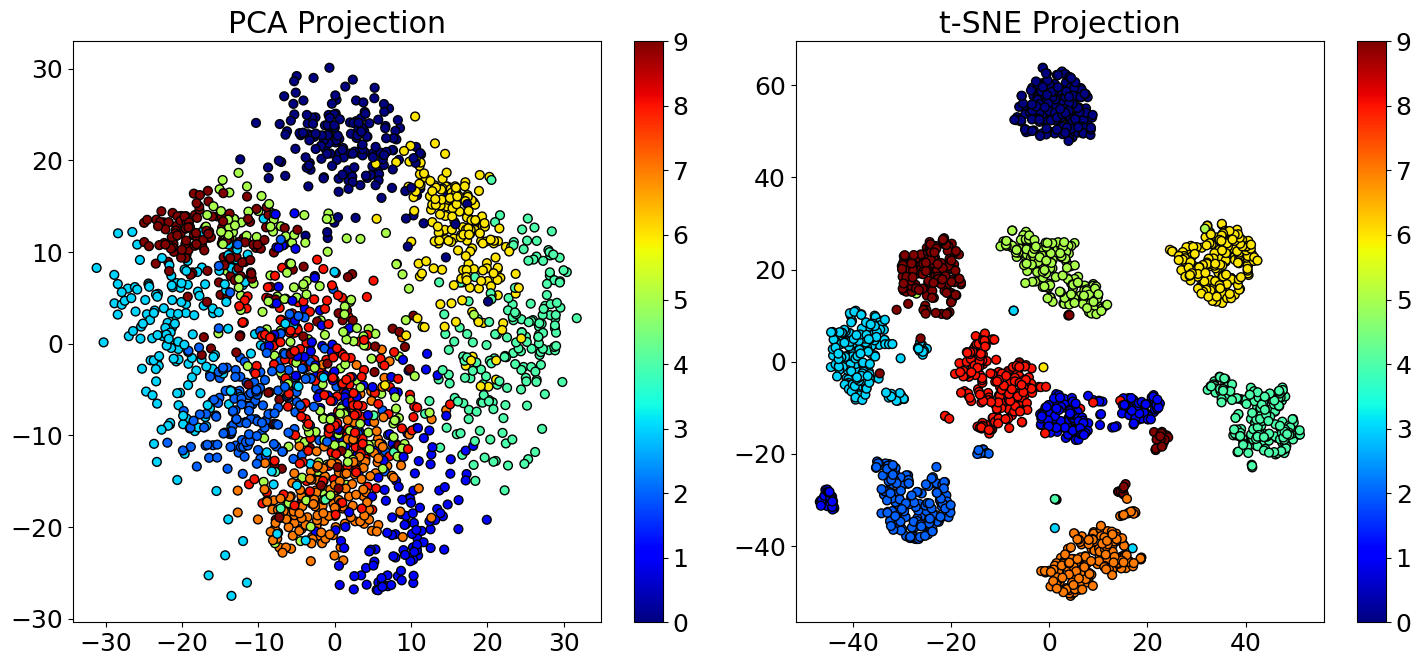

In [ ]:
#using pca and tsne  on the digits dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
tsne = TSNE(perplexity=30, n_components=2, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X)

#plotting stuff
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.jet, edgecolor='k', s=40)
plt.colorbar()
plt.title('PCA Projection')
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.jet, edgecolor='k', s=40)
plt.colorbar()
plt.title('t-SNE Projection')

plt.tight_layout()
plt.show()


Appendix. (Warning: this is a lot of pretty formal (but not too formal) math. I also assume you are familiar with some linear algebra, some calculus, and some matrix calculus identities. However if you don't know those things, I encourage you to try and read on and take in the main concepts which I explain in words.)


We start by stating our problem, we want to find the vector which explains the most possible variance. Therefore our first step is to find the vector $w$ that maximizes the variance of our data matrix $X$ when it is projected onto it.


We can express the variance in a direction $w$ as ${w^T Sw}$ . Where $S$ is our mean centered covariance matrix. This is a really cool linear algebra trick that express a seemingly abstract concept in a formal way. To see that lets look at what exactly this operation is doing.


 We do ${Sw}$ first, this will end up as an $M\times 1$ weighted combination of our variance. It can be useful to remember that matrix multiplication is a transformation that in this case scales, shifts, or stretches it depending on the variance. Now for the magic, when we multiply ${w^T }$ by ${Sw}$ we get out a scalar, this projection tells us how much of ${Sw}$ is "in the direction of $w$ ". In other words, ${w^T Sw}$ tells us how much variance there is in the direction of $w$.



Okay, so the objective is to find the direction that maximizes the variance of our data which we can represent as ${w^T Sw}$ . Now to introduce a constraint, we want $w$ to be a unit vector, or formally we want ${w^T w}=1$ . We want $w$ to be a unit vector because otherwise there would be infinitely many solutions because you could just scale $w$ to be infinitely long to capture "more and more" of the variance. You could of course pick some other constant besides 1 to be the length of our vector, but 1 is simple and it leads to this awesome solution.


Given our constraint ${w^T w}=1$ and the objective $w^* =argmax_w w^T Sw$ we have a constrained optimization problem. We can unconstrain this problem using lagrange multipliers, a fancy tool I'd never heard of until recently and they seem a bit like magic. Lagrange multipliers are typically written like:


$$L(w,\lambda )=Objective-\lambda (Constraint-1)$$

This gives us:


$$L(w,\lambda )=w^T Sw-\lambda (w^T w-1)$$

The intuiton here is that $\lambda$ provides us with a penalty when $w^T w$ is far away from 1. This constraint is enforced when we take the derivatives of $L$ with respect to $\lambda$ and set it to zero. We will do the same for $w$ to find the extrema of our function.


The gradient of $L$ with respect to $w$ is as follows:


 Differentiating the term ${w^T Sw}$ :


$$\frac{\partial }{\partial w}(w^T Sw)=2Sw$$

For the term $\lambda w^T w$ :


$$\frac{\partial }{\partial w}(\lambda w^T w)=2\lambda w$$

Putting those together:

$$\frac{\partial L}{\partial w}=2Sw-2\lambda w$$

Rearranging we get:


$$Sw=\lambda w$$

Does this look familiar??????? It's okay if it doesn't but if it does I hope that was cool, it's an eigenvalue problem! Our eigenvector is $w$ and our eigenvalue is $\lambda$! Thus, the direction that explains the most variance is the eigenvector of our covariance matrix. I won't break it all down but one way to then find the next eigenvectors which explain the next most variance and is orthogonal to the last is through a method called deflation.


Essentially it works by computing the outer product of $w$ , $P={{ww}}^T$ , then "deflating":


$$S_{deflated} =S-\lambda P$$

then solving for the eigenvectors and values of $S_{deflated}$ and so on.


Oh and don't think I forgot about The gradient of $L$ with respect to $\lambda$ , it works out to just be our original constraint which is what we want (thats the beauty of lagrange multipliers).
